In [7]:
# --- INSTALLS (Colab) ---
!pip -q install nltk==3.9.1 scikit-learn==1.5.2 xgboost==2.1.1 lightgbm==4.5.0 tqdm==4.66.5

# --- IMPORTS ---
import os, re, string, pickle, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from tqdm import tqdm
from pprint import pprint

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support, classification_report,
                             confusion_matrix, roc_auc_score, roc_curve, auc,
                             average_precision_score, precision_recall_curve)

from sklearn.linear_model import LogisticRegression


from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from scipy import sparse

# --- TEXT PREP (NLTK) ---
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize

# --- TF-IDF ---
from sklearn.feature_extraction.text import TfidfVectorizer

# --- PLOTTING ---
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.dpi"] = 130

RNG = 42

# --- DRIVE ---
from google.colab import drive
drive.mount('/content/drive')

# --- PATHS ---
CSV_PATH = "/content/drive/MyDrive/THESIS 47/Saved Datasets/[Non English reviews deleted] All_Language_Data.csv"
BASE_SAVE_DIR = "/content/drive/MyDrive/THESIS 47/ClassicML"
os.makedirs(BASE_SAVE_DIR, exist_ok=True)

# --- LOAD ---
df = pd.read_csv(CSV_PATH)

# --- BASIC CLEANING  ---
need = ['title','reviewText','sentiment_label','tomatoMeter','genre','audienceScore',
        'runtimeMinutes','language_encoded','director_encoded']
missing = [c for c in need if c not in df.columns]
assert not missing, f"Missing columns: {missing}"

df = df.dropna(subset=['reviewText','sentiment_label']).copy()
df['label'] = df['sentiment_label'].astype(int)

# keep only the columns we’ll need
df['title'] = df['title'].fillna("")
df['genre'] = df['genre'].fillna("Unknown")

class_names = ['Negative','Positive']
print("Rows:", len(df), "| Pos rate:", df['label'].mean().round(4))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Mounted at /content/drive
Rows: 194801 | Pos rate: 0.5019


In [8]:
############################
# TEXT PREPROCESS + TF-IDF #
############################

STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean_text(s: str) -> str:
    if not isinstance(s, str):
        s = "" if pd.isna(s) else str(s)
    s = s.lower()
    # contractions (quick pass)
    s = re.sub(r"’", "'", s)
    s = re.sub(r"n't\b", " not", s)
    s = re.sub(r"'re\b", " are", s)
    s = re.sub(r"'s\b", " is", s)
    s = re.sub(r"'d\b", " would", s)
    s = re.sub(r"'ll\b", " will", s)
    s = re.sub(r"'ve\b", " have", s)
    s = re.sub(r"'m\b", " am", s)
    # remove urls/emails/handles
    s = re.sub(r"http\S+|www\.\S+|[\w\.-]+@[\w\.-]+", " ", s)
    # keep letters only
    s = re.sub(r"[^a-z\s]", " ", s)
    # tokenize → remove stopwords → lemmatize → (light) stem
    tokens = [w for w in word_tokenize(s) if w not in STOPWORDS and len(w) > 2]
    lemmas = [lemmatizer.lemmatize(w) for w in tokens]
    stems  = [stemmer.stem(w) for w in lemmas]
    return " ".join(stems)

def fit_tfidf(train_texts, max_features=50000, ngram_range=(1,2), min_df=3):
    vec = TfidfVectorizer(
        preprocessor=None,
        tokenizer=None,
        analyzer='word',
        ngram_range=ngram_range,
        min_df=min_df,
        max_features=max_features,
        lowercase=False, # we already cleaned
        dtype=np.float32
    )
    X = vec.fit_transform(train_texts)
    return vec, X

def transform_tfidf(vec, texts):
    return vec.transform(texts)

#############################################
# DIRECTOR FEATURES: freq + leak-safe target
#############################################
def director_blocks(train_s: pd.Series, y: np.ndarray, test_s: pd.Series, n_splits=5):
    s_train = train_s.fillna("Unknown").astype(str)
    s_test  = test_s.fillna("Unknown").astype(str)

    freq = s_train.value_counts()
    tr_freq = s_train.map(freq).fillna(0).astype(float).values
    te_freq = s_test.map(freq).fillna(0).astype(float).values
    tr_freq = np.log1p(tr_freq)[:, None].astype(np.float32)
    te_freq = np.log1p(te_freq)[:, None].astype(np.float32)

    global_mean = y.mean()
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RNG)
    tr_te = np.zeros(len(s_train), dtype=np.float32)
    for tr_i, val_i in skf.split(np.zeros(len(y)), y):
        tr_part = s_train.iloc[tr_i]
        y_part  = y[tr_i]
        means = y_part.groupby(tr_part).mean()
        tr_te[val_i] = s_train.iloc[val_i].map(means).fillna(global_mean).astype(np.float32).values
    full_means = y.groupby(s_train).mean()
    te_te = s_test.map(full_means).fillna(global_mean).astype(np.float32).values[:, None]
    return tr_freq, te_freq, tr_te[:, None], te_te

##############################
# GENRE & LANGUAGE ENCODINGS #
##############################
def fit_categoricals(train_genre, train_lang):
    mlb = MultiLabelBinarizer()
    G = mlb.fit_transform(train_genre)

    ohe = OneHotEncoder(handle_unknown='ignore', sparse=True, dtype=np.float32)
    L = ohe.fit_transform(train_lang.to_frame(name="lang"))
    return mlb, ohe, G, L

def transform_categoricals(mlb, ohe, genre_series, lang_series):
    G = mlb.transform(genre_series)
    L = ohe.transform(lang_series.to_frame(name="lang"))
    return G, L

###################################
# NUMERICS: scale on TRAIN only   #
###################################
def fit_scale_numeric(train_df, cols):
    scaler = StandardScaler()
    X = scaler.fit_transform(train_df[cols].fillna(train_df[cols].median()))
    return scaler, X

def transform_scale_numeric(scaler, df, cols):
    return scaler.transform(df[cols].fillna(df[cols].median()))

###################################
# METRICS / PLOTTING HELPERS      #
###################################
def evaluate_and_plot(model_name, setup_name, y_true, y_prob, y_pred, save_dir):
    os.makedirs(save_dir, exist_ok=True)

    acc  = accuracy_score(y_true, y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    roc = roc_auc_score(y_true, y_prob) if y_prob is not None else np.nan
    ap  = average_precision_score(y_true, y_prob) if y_prob is not None else np.nan

    print(f"\n[{setup_name} | {model_name}]  Accuracy={acc:.4f}  F1={f1:.4f}  Precision={pr:.4f}  Recall={rc:.4f}  ROC-AUC={roc:.4f}  AP={ap:.4f}")
    print("\nClassification report:\n", classification_report(y_true, y_pred, target_names=['Negative','Positive'], zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    plt.figure(figsize=(4.2,3.6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Neg','Pos'], yticklabels=['Neg','Pos'])
    plt.title(f"{setup_name} | {model_name}\nConfusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout(); plt.show()

    # ROC
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        plt.figure(figsize=(4.2,3.6))
        plt.plot(fpr, tpr, lw=2)
        plt.plot([0,1],[0,1],'--')
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{setup_name} | {model_name}\nROC curve (AUC={roc:.3f})")
        plt.tight_layout(); plt.show()

        # PR
        P, R, _ = precision_recall_curve(y_true, y_prob)
        pr_auc = auc(R, P)
        plt.figure(figsize=(4.2,3.6))
        plt.plot(R, P, lw=2)
        plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"{setup_name} | {model_name}\nPR curve (AUC={pr_auc:.3f})")
        plt.tight_layout(); plt.show()

    return {"accuracy":acc, "f1":f1, "precision":pr, "recall":rc, "roc_auc":roc, "ap":ap}

def kfold_cv_report(model, X, y, name, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RNG)
    scores = []
    for fold, (tr, va) in enumerate(skf.split(X, y), 1):
        mdl = pickle.loads(pickle.dumps(model))  # deep copy
        mdl.fit(X[tr], y[tr])
        pred = mdl.predict(X[va])
        acc = accuracy_score(y[va], pred)
        f1  = precision_recall_fscore_support(y[va], pred, average='binary', zero_division=0)[2]
        scores.append((acc,f1))
        print(f"  Fold {fold}: acc={acc:.4f} | f1={f1:.4f}")
    arr = np.array(scores)
    print(f"  {name} CV mean±std  |  acc={arr[:,0].mean():.4f}±{arr[:,0].std():.4f}  f1={arr[:,1].mean():.4f}±{arr[:,1].std():.4f}")


In [9]:
import nltk
nltk.download('punkt')       # sentence/word tokenization data
nltk.download('punkt_tab')   # NEW in nltk>=3.9
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [10]:
# --- helpers: updated to support sklearn >= 1.2 (sparse_output) ---
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.model_selection import StratifiedKFold, train_test_split
import numpy as np, pandas as pd, sklearn
from packaging import version
from scipy import sparse

RNG = 42  # keep consistent with the rest of your notebook

def fit_categoricals(train_genre, train_lang):
    """
    Fits MultiLabelBinarizer on genre (list-like strings) and OneHotEncoder on language.
    Returns: mlb, ohe, G_train (csr), L_train (csr)
    """
    mlb = MultiLabelBinarizer()
    G = mlb.fit_transform(train_genre).astype(np.float32)

    if version.parse(sklearn.__version__) >= version.parse("1.2"):
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True, dtype=np.float32)
    else:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=True, dtype=np.float32)

    L = ohe.fit_transform(train_lang.to_frame(name="lang"))
    # ensure csr
    if not sparse.issparse(L): L = sparse.csr_matrix(L, dtype=np.float32)
    G = sparse.csr_matrix(G, dtype=np.float32)
    return mlb, ohe, G, L

def transform_categoricals(mlb, ohe, genre_series, lang_series):
    """
    Transforms genre & language using fitted encoders.
    Returns: G_test (csr), L_test (csr)
    """
    G = mlb.transform(genre_series).astype(np.float32)
    L = ohe.transform(lang_series.to_frame(name="lang"))
    if not sparse.issparse(L): L = sparse.csr_matrix(L, dtype=np.float32)
    G = sparse.csr_matrix(G, dtype=np.float32)
    return G, L

# --- FIXED director_blocks (wrap y as Series for groupby) ---
def director_blocks(train_s: pd.Series, y: np.ndarray, test_s: pd.Series, n_splits: int = 5):
    """
    Leak-safe director features:
      - log1p frequency from TRAIN only
      - K-fold target mean on TRAIN (out-of-fold)
      - Test target mean from FULL train means
    """
    # Clean inputs
    s_train = train_s.fillna("Unknown").astype(str)
    s_test  = test_s.fillna("Unknown").astype(str)

    # Frequency features (log1p), computed on TRAIN only
    freq = s_train.value_counts()
    tr_freq = np.log1p(s_train.map(freq).fillna(0).astype(float).values)[:, None].astype(np.float32)
    te_freq = np.log1p(s_test.map(freq).fillna(0).astype(float).values)[:, None].astype(np.float32)

    # Target mean encoding (binary target); do it leak-safe with OOF means
    global_mean = float(np.mean(y))
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RNG)

    tr_te = np.zeros(len(s_train), dtype=np.float32)
    for tr_idx, val_idx in skf.split(np.zeros(len(y)), y):
        tr_part = s_train.iloc[tr_idx]
        y_part  = pd.Series(y[tr_idx], index=tr_part.index, dtype=float)
        means = y_part.groupby(tr_part).mean()
        tr_te[val_idx] = (
            s_train.iloc[val_idx].map(means).fillna(global_mean).astype(np.float32).values
        )

    # Test: map with means computed on FULL train (safe—applied only to test)
    y_full = pd.Series(y, index=s_train.index, dtype=float)
    full_means = y_full.groupby(s_train).mean()
    te_te = s_test.map(full_means).fillna(global_mean).astype(np.float32).values[:, None]

    return tr_freq, te_freq, tr_te[:, None], te_te

# ======================================================================
# Build ALL-FEATURE matrices (uses your existing clean_text/tfidf helpers)
# ======================================================================

# --- train/test split (stratified) ---
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=RNG, stratify=df['label']
)
y_train = train_df['label'].to_numpy().astype(int)
y_test  = test_df['label'].to_numpy().astype(int)

# --- TEXT (reviewText only, per your constraint not to mix with title) ---
# relies on your previously defined clean_text / fit_tfidf / transform_tfidf
train_text = train_df['reviewText'].map(clean_text)
test_text  = test_df['reviewText'].map(clean_text)
tfidf_all, Xtr_text = fit_tfidf(train_text, max_features=60000, ngram_range=(1,2), min_df=3)
Xte_text = transform_tfidf(tfidf_all, test_text)

# --- NUMERICS (3 cols) ---
# relies on your previously defined fit_scale_numeric / transform_scale_numeric
NUM_COLS = ['tomatoMeter','audienceScore','runtimeMinutes']
scaler_all, Xtr_num_np = fit_scale_numeric(train_df, NUM_COLS)
Xte_num_np = transform_scale_numeric(scaler_all, test_df, NUM_COLS)
Xtr_num = sparse.csr_matrix(Xtr_num_np.astype(np.float32))
Xte_num = sparse.csr_matrix(Xte_num_np.astype(np.float32))

# --- CATEGORICALS (genre multi-hot + language OHE) ---
train_genre = train_df['genre'].fillna("Unknown").str.split(', ')
test_genre  = test_df['genre'].fillna("Unknown").str.split(', ')
train_lang  = train_df['language_encoded'].astype('Int64').astype(str).fillna('unknown')
test_lang   = test_df['language_encoded'].astype('Int64').astype(str).fillna('unknown')

mlb_all, ohe_all, Xtr_genre, Xtr_lang = fit_categoricals(train_genre, train_lang)
Xte_genre, Xte_lang = transform_categoricals(mlb_all, ohe_all, test_genre, test_lang)

# --- DIRECTOR: freq + target mean (2 cols) ---
if 'director' in df.columns:
    tr_f, te_f, tr_te, te_te = director_blocks(train_df['director'], y_train, test_df['director'])
else:
    tr_f, te_f, tr_te, te_te = director_blocks(
        train_df['director_encoded'], y_train, test_df['director_encoded']
    )

Xtr_dir_np = np.concatenate([tr_f, tr_te], axis=1).astype(np.float32)
Xte_dir_np = np.concatenate([te_f, te_te], axis=1).astype(np.float32)
Xtr_dir = sparse.csr_matrix(Xtr_dir_np)
Xte_dir = sparse.csr_matrix(Xte_dir_np)

# --- STACK ALL ---
X_train_ALL = sparse.hstack([Xtr_text, Xtr_num, Xtr_genre, Xtr_lang, Xtr_dir], format='csr')
X_test_ALL  = sparse.hstack([Xte_text, Xte_num, Xte_genre, Xte_lang, Xte_dir], format='csr')

print("ALL-FEATURES shapes:", X_train_ALL.shape, X_test_ALL.shape)


ALL-FEATURES shapes: (155840, 60051) (38961, 60051)


**ML Models All features**

  Fold 1: acc=0.8321 | f1=0.8338
  Fold 2: acc=0.8325 | f1=0.8340
  Fold 3: acc=0.8336 | f1=0.8345
  Fold 4: acc=0.8312 | f1=0.8329
  Fold 5: acc=0.8326 | f1=0.8338
  LogReg (ALL) CV mean±std  |  acc=0.8324±0.0008  f1=0.8338±0.0005

Train accuracy: 0.8689810061601643
Test  accuracy: 0.8341675008341675

[ALL_FEATURES | LogisticRegression]  Accuracy=0.8342  F1=0.8355  Precision=0.8319  Recall=0.8392  ROC-AUC=0.9144  AP=0.9166

Classification report:
               precision    recall  f1-score   support

    Negative       0.84      0.83      0.83     19408
    Positive       0.83      0.84      0.84     19553

    accuracy                           0.83     38961
   macro avg       0.83      0.83      0.83     38961
weighted avg       0.83      0.83      0.83     38961



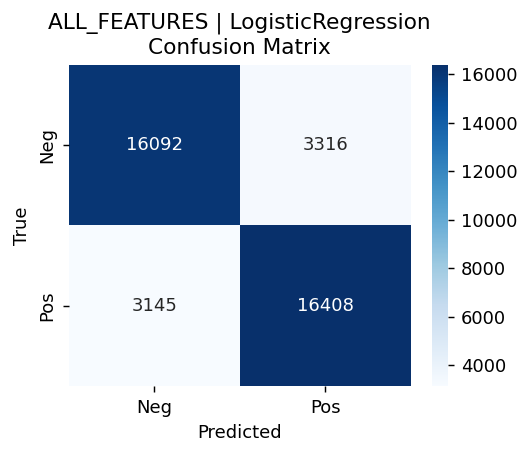

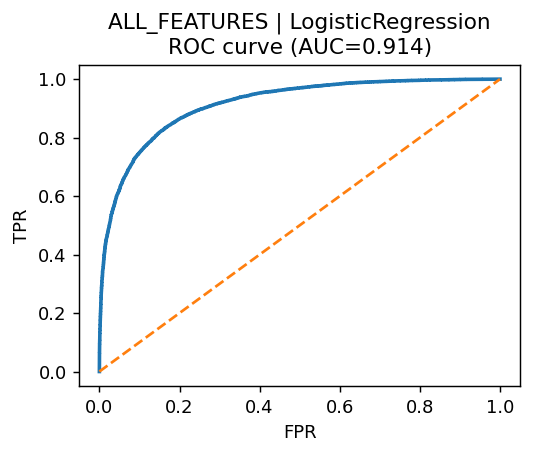

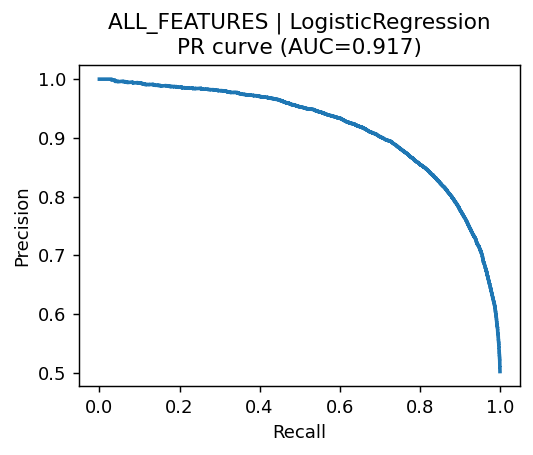

In [8]:
setup = "ALL_FEATURES"
save_dir = os.path.join(BASE_SAVE_DIR, setup); os.makedirs(save_dir, exist_ok=True)

logreg_all = LogisticRegression(
    penalty="l2", solver="lbfgs", max_iter=2000, n_jobs=-1, class_weight="balanced"
)

# K-Fold on TRAIN
kfold_cv_report(logreg_all, X_train_ALL, y_train, "LogReg (ALL)")

# Fit on TRAIN, evaluate on TRAIN + TEST
logreg_all.fit(X_train_ALL, y_train)
train_pred = logreg_all.predict(X_train_ALL)
test_pred  = logreg_all.predict(X_test_ALL)
try:
    test_prob = logreg_all.predict_proba(X_test_ALL)[:,1]
    train_prob = logreg_all.predict_proba(X_train_ALL)[:,1]
except Exception:
    test_prob = None; train_prob = None

print("\nTrain accuracy:", accuracy_score(y_train, train_pred))
print("Test  accuracy:", accuracy_score(y_test,  test_pred))

evaluate_and_plot("LogisticRegression", setup, y_test, test_prob, test_pred, save_dir)

# Save artifacts
with open(os.path.join(save_dir, "LogReg_ALL.pkl"), "wb") as f:
    pickle.dump({"model":logreg_all,
                 "tfidf":tfidf_all, "scaler":scaler_all, "mlb":mlb_all, "ohe":ohe_all,
                 "num_cols":NUM_COLS}, f)


  Fold 1: acc=0.8019 | f1=0.8034
  Fold 2: acc=0.8014 | f1=0.8031
  Fold 3: acc=0.8024 | f1=0.8040
  Fold 4: acc=0.8030 | f1=0.8045
  Fold 5: acc=0.8032 | f1=0.8042
  XGBoost (ALL) CV mean±std  |  acc=0.8024±0.0007  f1=0.8038±0.0005

Train accuracy: 0.8180184804928131
Test  accuracy: 0.8009034675701342

[ALL_FEATURES | XGBoost]  Accuracy=0.8009  F1=0.8012  Precision=0.8031  Recall=0.7992  ROC-AUC=0.8842  AP=0.8878

Classification report:
               precision    recall  f1-score   support

    Negative       0.80      0.80      0.80     19408
    Positive       0.80      0.80      0.80     19553

    accuracy                           0.80     38961
   macro avg       0.80      0.80      0.80     38961
weighted avg       0.80      0.80      0.80     38961



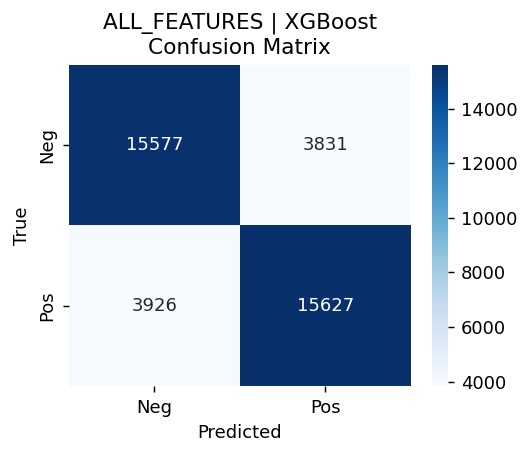

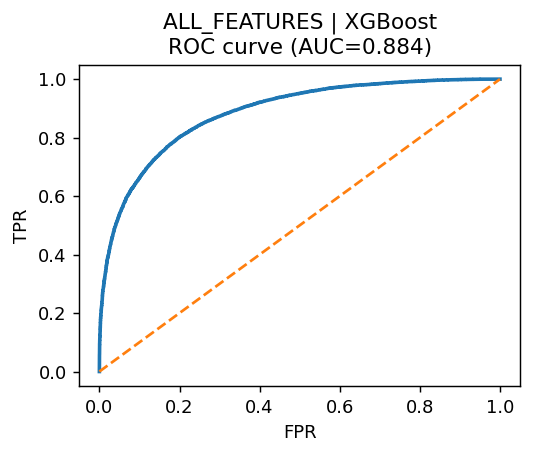

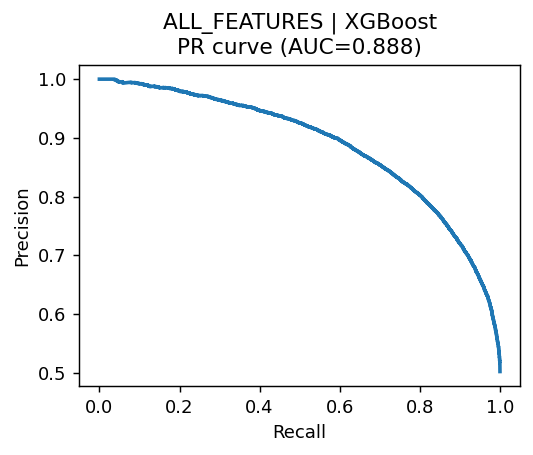

In [10]:
setup = "ALL_FEATURES"
save_dir = os.path.join(BASE_SAVE_DIR, setup); os.makedirs(save_dir, exist_ok=True)

xgb_all = XGBClassifier(
    n_estimators=500, max_depth=6, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8,
    reg_lambda=1.0, reg_alpha=0.0, random_state=RNG, n_jobs=-1,
    tree_method="hist", objective="binary:logistic", eval_metric="logloss"
)

kfold_cv_report(xgb_all, X_train_ALL, y_train, "XGBoost (ALL)")

xgb_all.fit(X_train_ALL, y_train)
train_pred = xgb_all.predict(X_train_ALL)
test_pred  = xgb_all.predict(X_test_ALL)
test_prob  = xgb_all.predict_proba(X_test_ALL)[:,1]
train_prob = xgb_all.predict_proba(X_train_ALL)[:,1]

print("\nTrain accuracy:", accuracy_score(y_train, train_pred))
print("Test  accuracy:", accuracy_score(y_test,  test_pred))
evaluate_and_plot("XGBoost", setup, y_test, test_prob, test_pred, save_dir)

with open(os.path.join(save_dir, "XGBoost_ALL.pkl"), "wb") as f:
    pickle.dump({"model":xgb_all,
                 "tfidf":tfidf_all, "scaler":scaler_all, "mlb":mlb_all, "ohe":ohe_all,
                 "num_cols":NUM_COLS}, f)


[LightGBM] [Info] Number of positive: 62569, number of negative: 62103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 16.305121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 392673
[LightGBM] [Info] Number of data points in the train set: 124672, number of used features: 10451
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501869 -> initscore=0.007476
[LightGBM] [Info] Start training from score 0.007476
  Fold 1: acc=0.8273 | f1=0.8284
[LightGBM] [Info] Number of positive: 62569, number of negative: 62103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 15.824208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 392797
[LightGBM] [Info] Number of data points in the train set: 124672, numb

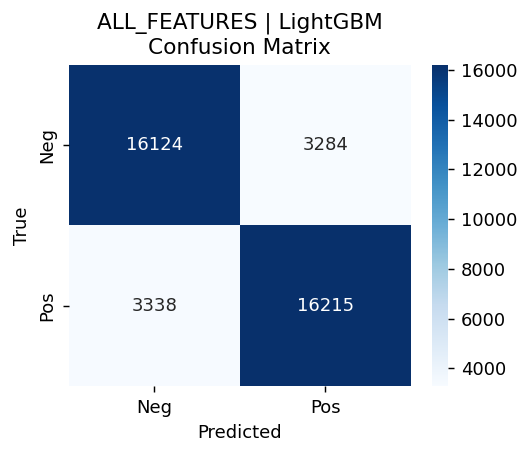

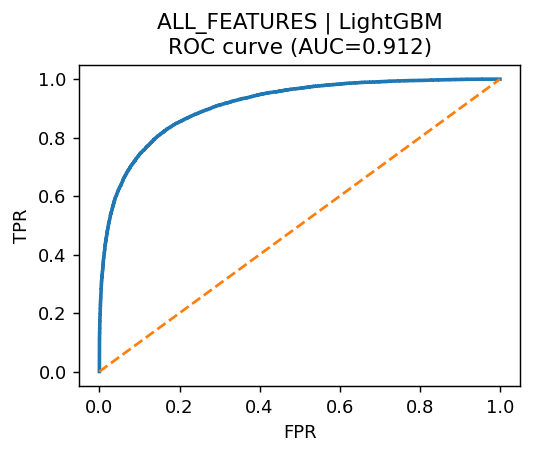

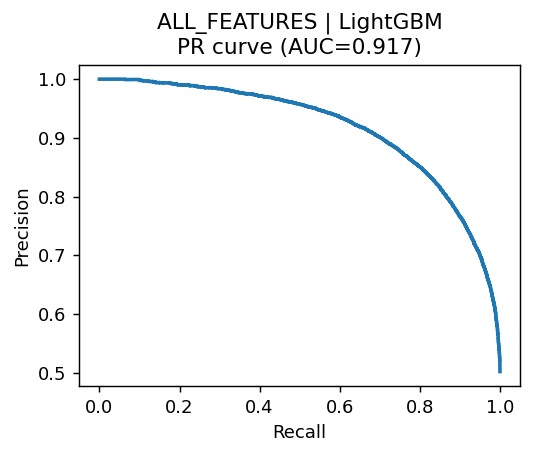

In [11]:
setup = "ALL_FEATURES"
save_dir = os.path.join(BASE_SAVE_DIR, setup); os.makedirs(save_dir, exist_ok=True)

lgb_all = LGBMClassifier(
    n_estimators=600, learning_rate=0.05, max_depth=-1, num_leaves=64,
    subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0, random_state=RNG, n_jobs=-1
)

kfold_cv_report(lgb_all, X_train_ALL, y_train, "LightGBM (ALL)")

lgb_all.fit(X_train_ALL, y_train)
train_pred = lgb_all.predict(X_train_ALL)
test_pred  = lgb_all.predict(X_test_ALL)
test_prob  = lgb_all.predict_proba(X_test_ALL)[:,1]
train_prob = lgb_all.predict_proba(X_train_ALL)[:,1]

print("\nTrain accuracy:", accuracy_score(y_train, train_pred))
print("Test  accuracy:", accuracy_score(y_test,  test_pred))
evaluate_and_plot("LightGBM", setup, y_test, test_prob, test_pred, save_dir)

with open(os.path.join(save_dir, "LightGBM_ALL.pkl"), "wb") as f:
    pickle.dump({"model":lgb_all,
                 "tfidf":tfidf_all, "scaler":scaler_all, "mlb":mlb_all, "ohe":ohe_all,
                 "num_cols":NUM_COLS}, f)


In [12]:
# =========================================
# SAVE ALL-FEATURE MODELS (already trained)
# =========================================
with open("/content/drive/MyDrive/THESIS 47/LogReg_ALL.pkl", "wb") as f:
    pickle.dump({"model":logreg_all, "tfidf":tfidf_all, "scaler":scaler_all,
                 "mlb":mlb_all, "ohe":ohe_all, "num_cols":NUM_COLS}, f)

with open("/content/drive/MyDrive/THESIS 47/XGBoost_ALL.pkl", "wb") as f:
    pickle.dump({"model":xgb_all, "tfidf":tfidf_all, "scaler":scaler_all,
                 "mlb":mlb_all, "ohe":ohe_all, "num_cols":NUM_COLS}, f)

with open("/content/drive/MyDrive/THESIS 47/LightGBM_ALL.pkl", "wb") as f:
    pickle.dump({"model":lgb_all, "tfidf":tfidf_all, "scaler":scaler_all,
                 "mlb":mlb_all, "ohe":ohe_all, "num_cols":NUM_COLS}, f)

print("✅ ALL-FEATURE models saved to Drive")

✅ ALL-FEATURE models saved to Drive


**4-FEATURE” (review text + tomatoMeter + genre multi-hot)**

[TOP4_FEATURES] Selected (strong) C: 0.100000
  Fold 1: acc=0.8019 | f1=0.8060
  Fold 2: acc=0.7998 | f1=0.8047
  Fold 3: acc=0.8013 | f1=0.8059
  Fold 4: acc=0.8022 | f1=0.8071
  Fold 5: acc=0.8022 | f1=0.8057
  LogReg (TOP4, strong L2) CV mean±std  |  acc=0.8015±0.0009  f1=0.8059±0.0008

Train accuracy: 0.8226321868583162
Test  accuracy: 0.8081671415004749

[TOP4_FEATURES | LogisticRegression]  Accuracy=0.8082  F1=0.8119  Precision=0.7994  Recall=0.8247  ROC-AUC=0.8922  AP=0.8963

Classification report:
               precision    recall  f1-score   support

    Negative       0.82      0.79      0.80     19408
    Positive       0.80      0.82      0.81     19553

    accuracy                           0.81     38961
   macro avg       0.81      0.81      0.81     38961
weighted avg       0.81      0.81      0.81     38961



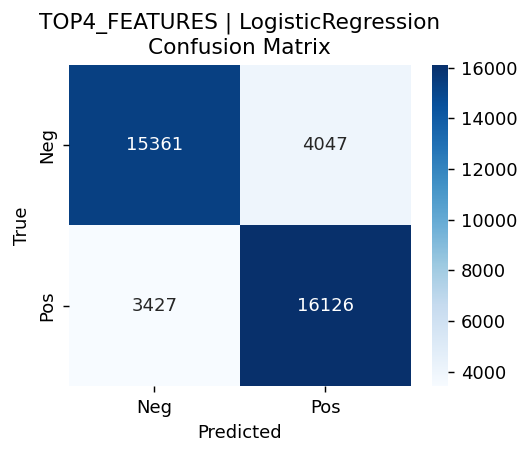

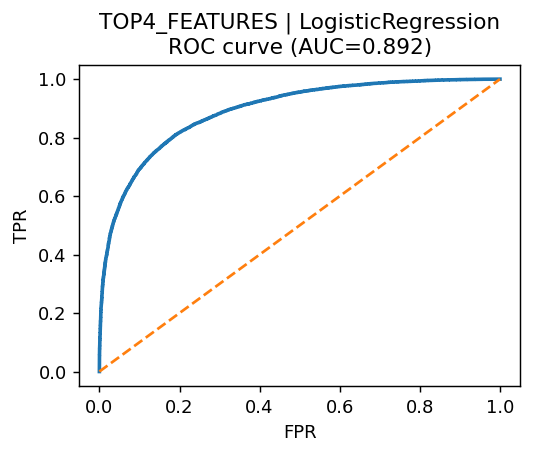

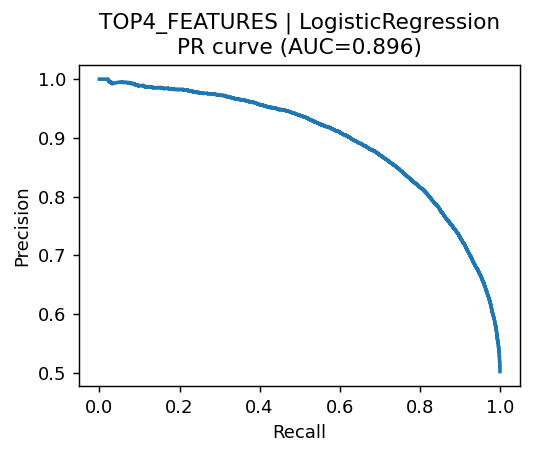

In [20]:
# ============================
# Logistic Regression — TOP 4  (stronger L2 regularization)
#   Features: reviewText, title, genre, tomatoMeter
# ============================

setup = "TOP4_FEATURES"
save_dir = os.path.join(BASE_SAVE_DIR, setup); os.makedirs(save_dir, exist_ok=True)

# ---- Build TOP-4 feature matrices (uses your existing helpers) ----
# Text: reviewText
train_review = train_df['reviewText'].map(clean_text)
test_review  = test_df['reviewText'].map(clean_text)
tfidf_review, Xtr_review = fit_tfidf(train_review, max_features=60000, ngram_range=(1,2), min_df=3)
Xte_review = transform_tfidf(tfidf_review, test_review)

# Text: title
train_title = train_df['title'].map(clean_text)
test_title  = test_df['title'].map(clean_text)
tfidf_title, Xtr_title = fit_tfidf(train_title, max_features=30000, ngram_range=(1,2), min_df=3)
Xte_title = transform_tfidf(tfidf_title, test_title)

# Categorical: genre (MultiLabelBinarizer)
train_genre = train_df['genre'].fillna("Unknown").str.split(', ')
test_genre  = test_df['genre'].fillna("Unknown").str.split(', ')
mlb_4 = MultiLabelBinarizer()
Xtr_genre = mlb_4.fit_transform(train_genre).astype(np.float32)
Xte_genre = mlb_4.transform(test_genre).astype(np.float32)
Xtr_genre = sparse.csr_matrix(Xtr_genre)
Xte_genre = sparse.csr_matrix(Xte_genre)

# Numeric: tomatoMeter (scaled on TRAIN only)
NUM_COLS_4 = ['tomatoMeter']
scaler_4, Xtr_num_np = fit_scale_numeric(train_df, NUM_COLS_4)
Xte_num_np = transform_scale_numeric(scaler_4, test_df, NUM_COLS_4)
Xtr_num = sparse.csr_matrix(Xtr_num_np.astype(np.float32))
Xte_num = sparse.csr_matrix(Xte_num_np.astype(np.float32))

# Stack TOP-4
X_train_TOP4 = sparse.hstack([Xtr_review, Xtr_title, Xtr_genre, Xtr_num], format='csr')
X_test_TOP4  = sparse.hstack([Xte_review, Xte_title, Xte_genre, Xte_num], format='csr')

# ---- Stronger regularization search (smaller Cs) ----
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

cs_grid = np.logspace(-4, -1, 10)  # much stronger L2 than before (0.0001 ... 0.1)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)

logreg_cv = LogisticRegressionCV(
    Cs=cs_grid,
    cv=inner_cv,
    penalty="l2",
    solver="lbfgs",
    max_iter=4000,
    class_weight="balanced",
    n_jobs=-1,
    scoring="f1",
    refit=True,
)
logreg_cv.fit(X_train_TOP4, y_train)
best_C = float(logreg_cv.C_[0])
print(f"[TOP4_FEATURES] Selected (strong) C: {best_C:.6f}")

# ---- Final model with tuned (small) C ----
logreg_top4 = LogisticRegression(
    penalty="l2",
    C=best_C,
    solver="lbfgs",
    max_iter=4000,
    n_jobs=-1,
    class_weight="balanced",
)

# K-Fold on TRAIN (using tuned C)
kfold_cv_report(logreg_top4, X_train_TOP4, y_train, "LogReg (TOP4, strong L2)")

# Fit on TRAIN, evaluate on TRAIN + TEST
logreg_top4.fit(X_train_TOP4, y_train)
train_pred = logreg_top4.predict(X_train_TOP4)
test_pred  = logreg_top4.predict(X_test_TOP4)
try:
    test_prob = logreg_top4.predict_proba(X_test_TOP4)[:,1]
    train_prob = logreg_top4.predict_proba(X_train_TOP4)[:,1]
except Exception:
    test_prob = None; train_prob = None

print("\nTrain accuracy:", accuracy_score(y_train, train_pred))
print("Test  accuracy:", accuracy_score(y_test,  test_pred))

evaluate_and_plot("LogisticRegression", setup, y_test, test_prob, test_pred, save_dir)

# ---- Save artifacts (latest path) ----
with open("/content/drive/MyDrive/THESIS 47/LogReg_TOP4.pkl", "wb") as f:
    pickle.dump({
        "model":        logreg_top4,
        "best_C":       best_C,
        "tfidf_review": tfidf_review,
        "tfidf_title":  tfidf_title,
        "scaler":       scaler_4,
        "mlb":          mlb_4,
        "num_cols":     NUM_COLS_4
    }, f)


[TEXTONLY_FEATURE] Selected (strong) C: 0.100000
  Fold 1: acc=0.7624 | f1=0.7627
  Fold 2: acc=0.7620 | f1=0.7633
  Fold 3: acc=0.7669 | f1=0.7667
  Fold 4: acc=0.7631 | f1=0.7625
  Fold 5: acc=0.7632 | f1=0.7634
  LogReg (TEXT ONLY, strong L2) CV mean±std  |  acc=0.7635±0.0017  f1=0.7637±0.0015

Train accuracy: 0.7831686344969199
Test  accuracy: 0.7652267652267652

[TEXTONLY_FEATURE | LogisticRegression]  Accuracy=0.7652  F1=0.7662  Precision=0.7659  Recall=0.7665  ROC-AUC=0.8452  AP=0.8456

Classification report:
               precision    recall  f1-score   support

    Negative       0.76      0.76      0.76     19408
    Positive       0.77      0.77      0.77     19553

    accuracy                           0.77     38961
   macro avg       0.77      0.77      0.77     38961
weighted avg       0.77      0.77      0.77     38961



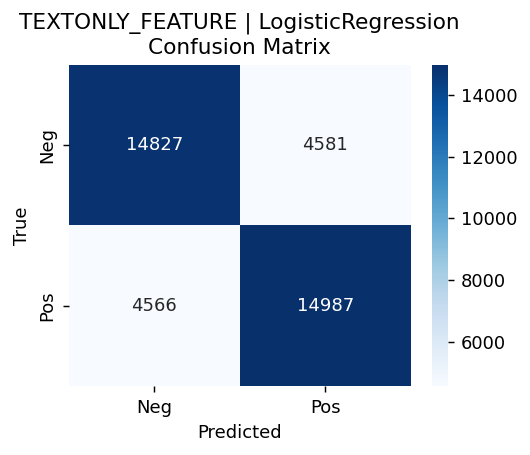

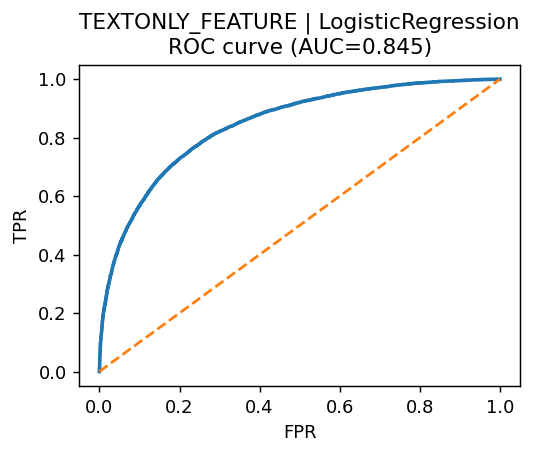

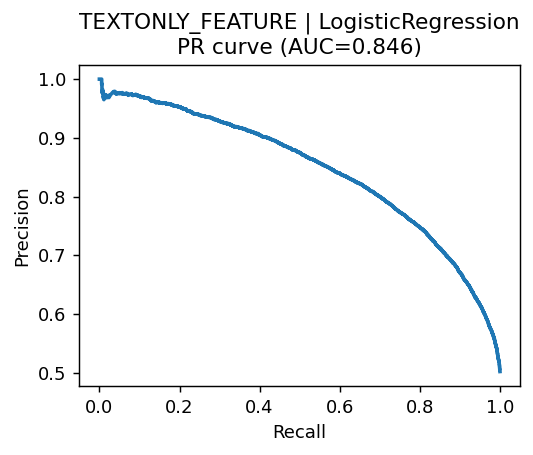

In [21]:
# ============================
# Logistic Regression — TEXT ONLY (stronger L2 regularization)
#   Feature: reviewText (TF-IDF)
# ============================

setup = "TEXTONLY_FEATURE"
save_dir = os.path.join(BASE_SAVE_DIR, setup); os.makedirs(save_dir, exist_ok=True)

# ---- Build TEXT-ONLY matrices (uses your existing helpers) ----
train_review = train_df['reviewText'].map(clean_text)
test_review  = test_df['reviewText'].map(clean_text)

tfidf_review, Xtr_review = fit_tfidf(
    train_review,
    max_features=60000,
    ngram_range=(1,2),
    min_df=3
)
Xte_review = transform_tfidf(tfidf_review, test_review)

# Use only the reviewText vectors
X_train_TEXT = Xtr_review
X_test_TEXT  = Xte_review

# ---- Stronger regularization search (smaller Cs) ----
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

cs_grid = np.logspace(-4, -1, 10)  # 0.0001 ... 0.1
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)

logreg_cv = LogisticRegressionCV(
    Cs=cs_grid,
    cv=inner_cv,
    penalty="l2",
    solver="lbfgs",
    max_iter=4000,
    class_weight="balanced",
    n_jobs=-1,
    scoring="f1",
    refit=True,
)
logreg_cv.fit(X_train_TEXT, y_train)
best_C = float(logreg_cv.C_[0])
print(f"[TEXTONLY_FEATURE] Selected (strong) C: {best_C:.6f}")

# ---- Final model with tuned (small) C ----
logreg_text = LogisticRegression(
    penalty="l2",
    C=best_C,
    solver="lbfgs",
    max_iter=4000,
    n_jobs=-1,
    class_weight="balanced",
)

# K-Fold on TRAIN (using tuned C)
kfold_cv_report(logreg_text, X_train_TEXT, y_train, "LogReg (TEXT ONLY, strong L2)")

# Fit on TRAIN, evaluate on TRAIN + TEST
logreg_text.fit(X_train_TEXT, y_train)
train_pred = logreg_text.predict(X_train_TEXT)
test_pred  = logreg_text.predict(X_test_TEXT)
try:
    test_prob = logreg_text.predict_proba(X_test_TEXT)[:,1]
    train_prob = logreg_text.predict_proba(X_train_TEXT)[:,1]
except Exception:
    test_prob = None; train_prob = None

print("\nTrain accuracy:", accuracy_score(y_train, train_pred))
print("Test  accuracy:", accuracy_score(y_test,  test_pred))

evaluate_and_plot("LogisticRegression", setup, y_test, test_prob, test_pred, save_dir)

# ---- Save artifacts (latest path) ----
with open("/content/drive/MyDrive/THESIS 47/LogReg_TEXTONLY.pkl", "wb") as f:
    pickle.dump({
        "model":        logreg_text,
        "best_C":       best_C,
        "tfidf_review": tfidf_review
    }, f)


  Fold 1: acc=0.7908 | f1=0.7927
  Fold 2: acc=0.7915 | f1=0.7941
  Fold 3: acc=0.7906 | f1=0.7927
  Fold 4: acc=0.7927 | f1=0.7955
  Fold 5: acc=0.7913 | f1=0.7931
  XGBoost (TOP4) CV mean±std  |  acc=0.7914±0.0008  f1=0.7936±0.0011

Train accuracy: 0.8064425051334703
Test  accuracy: 0.7902004568671235

[TOP4_FEATURES | XGBoost]  Accuracy=0.7902  F1=0.7919  Precision=0.7883  Recall=0.7956  ROC-AUC=0.8734  AP=0.8761

Classification report:
               precision    recall  f1-score   support

    Negative       0.79      0.78      0.79     19408
    Positive       0.79      0.80      0.79     19553

    accuracy                           0.79     38961
   macro avg       0.79      0.79      0.79     38961
weighted avg       0.79      0.79      0.79     38961



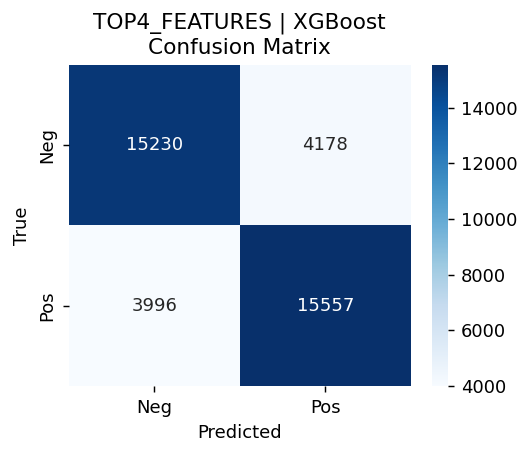

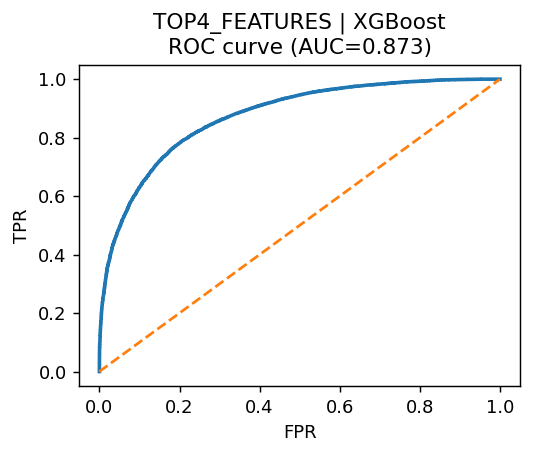

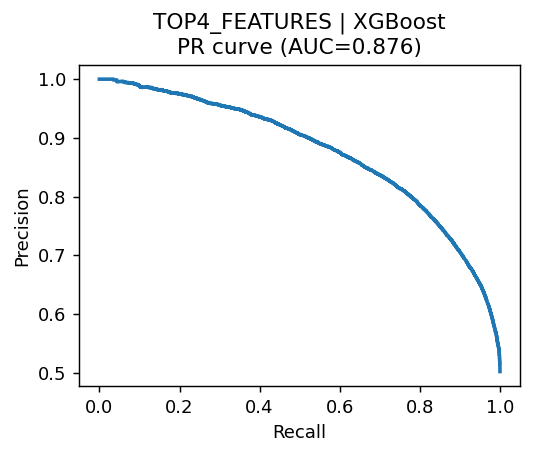

In [22]:
# ============================
# XGBoost — TOP 4 FEATURES
#   Features: reviewText, title, genre, tomatoMeter
# ============================

setup = "TOP4_FEATURES"
save_dir = os.path.join(BASE_SAVE_DIR, setup); os.makedirs(save_dir, exist_ok=True)

# ---- Build TOP-4 feature matrices (same as your LogReg TOP-4 block) ----
# Text: reviewText
train_review = train_df['reviewText'].map(clean_text)
test_review  = test_df['reviewText'].map(clean_text)
tfidf_review, Xtr_review = fit_tfidf(train_review, max_features=60000, ngram_range=(1,2), min_df=3)
Xte_review = transform_tfidf(tfidf_review, test_review)

# Text: title
train_title = train_df['title'].map(clean_text)
test_title  = test_df['title'].map(clean_text)
tfidf_title, Xtr_title = fit_tfidf(train_title, max_features=30000, ngram_range=(1,2), min_df=3)
Xte_title = transform_tfidf(tfidf_title, test_title)

# Categorical: genre (MultiLabelBinarizer)
train_genre = train_df['genre'].fillna("Unknown").str.split(', ')
test_genre  = test_df['genre'].fillna("Unknown").str.split(', ')
mlb_4 = MultiLabelBinarizer()
Xtr_genre = mlb_4.fit_transform(train_genre).astype(np.float32)
Xte_genre = mlb_4.transform(test_genre).astype(np.float32)
Xtr_genre = sparse.csr_matrix(Xtr_genre)
Xte_genre = sparse.csr_matrix(Xte_genre)

# Numeric: tomatoMeter (scaled on TRAIN only)
NUM_COLS_4 = ['tomatoMeter']
scaler_4, Xtr_num_np = fit_scale_numeric(train_df, NUM_COLS_4)
Xte_num_np = transform_scale_numeric(scaler_4, test_df, NUM_COLS_4)
Xtr_num = sparse.csr_matrix(Xtr_num_np.astype(np.float32))
Xte_num = sparse.csr_matrix(Xte_num_np.astype(np.float32))

# Stack TOP-4
X_train_TOP4 = sparse.hstack([Xtr_review, Xtr_title, Xtr_genre, Xtr_num], format='csr')
X_test_TOP4  = sparse.hstack([Xte_review, Xte_title, Xte_genre, Xte_num], format='csr')

# ---- Model ----
xgb_top4 = XGBClassifier(
    n_estimators=500, max_depth=6, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8,
    reg_lambda=1.0, reg_alpha=0.0,
    random_state=RNG, n_jobs=-1,
    tree_method="hist", objective="binary:logistic", eval_metric="logloss"
)

# K-Fold on TRAIN
kfold_cv_report(xgb_top4, X_train_TOP4, y_train, "XGBoost (TOP4)")

# Fit on TRAIN, evaluate on TRAIN + TEST
xgb_top4.fit(X_train_TOP4, y_train)
train_pred = xgb_top4.predict(X_train_TOP4)
test_pred  = xgb_top4.predict(X_test_TOP4)
test_prob  = xgb_top4.predict_proba(X_test_TOP4)[:,1]
train_prob = xgb_top4.predict_proba(X_train_TOP4)[:,1]

print("\nTrain accuracy:", accuracy_score(y_train, train_pred))
print("Test  accuracy:", accuracy_score(y_test,  test_pred))
evaluate_and_plot("XGBoost", setup, y_test, test_prob, test_pred, save_dir)

# Save artifacts
with open(os.path.join(save_dir, "XGBoost_TOP4.pkl"), "wb") as f:
    pickle.dump({
        "model":        xgb_top4,
        "tfidf_review": tfidf_review,
        "tfidf_title":  tfidf_title,
        "scaler":       scaler_4,
        "mlb":          mlb_4,
        "num_cols":     NUM_COLS_4
    }, f)


  Fold 1: acc=0.7249 | f1=0.7200
  Fold 2: acc=0.7209 | f1=0.7160
  Fold 3: acc=0.7222 | f1=0.7160
  Fold 4: acc=0.7179 | f1=0.7109
  Fold 5: acc=0.7227 | f1=0.7164
  XGBoost (TEXT ONLY) CV mean±std  |  acc=0.7217±0.0023  f1=0.7159±0.0029

Train accuracy: 0.7444686858316222
Test  accuracy: 0.7179230512563846

[TEXTONLY_FEATURE | XGBoost]  Accuracy=0.7179  F1=0.7101  Precision=0.7332  Recall=0.6884  ROC-AUC=0.7936  AP=0.7907

Classification report:
               precision    recall  f1-score   support

    Negative       0.70      0.75      0.73     19408
    Positive       0.73      0.69      0.71     19553

    accuracy                           0.72     38961
   macro avg       0.72      0.72      0.72     38961
weighted avg       0.72      0.72      0.72     38961



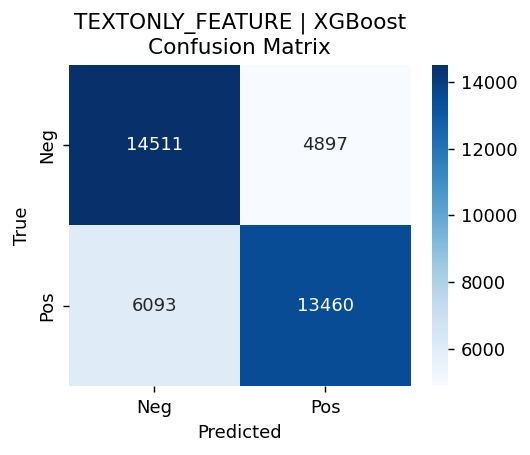

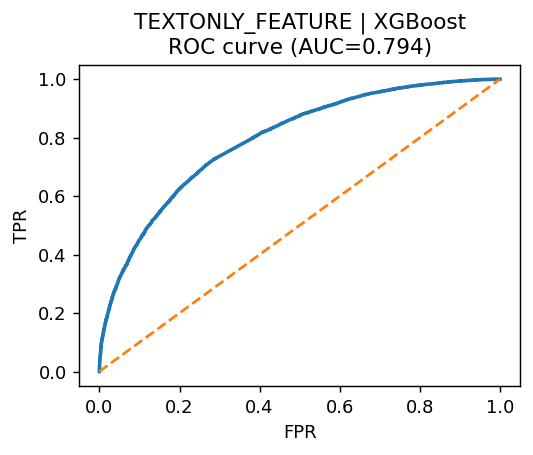

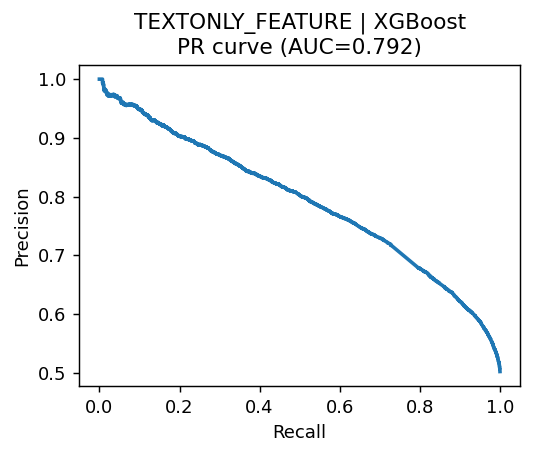

In [23]:
# ============================
# XGBoost — TEXT ONLY
#   Feature: reviewText (TF-IDF)
# ============================

setup = "TEXTONLY_FEATURE"
save_dir = os.path.join(BASE_SAVE_DIR, setup); os.makedirs(save_dir, exist_ok=True)

# ---- Build TEXT-ONLY matrices (same as your LogReg TEXT ONLY block) ----
train_review = train_df['reviewText'].map(clean_text)
test_review  = test_df['reviewText'].map(clean_text)

tfidf_review, Xtr_review = fit_tfidf(
    train_review,
    max_features=60000,
    ngram_range=(1,2),
    min_df=3
)
Xte_review = transform_tfidf(tfidf_review, test_review)

X_train_TEXT = Xtr_review
X_test_TEXT  = Xte_review

# ---- Model ----
xgb_text = XGBClassifier(
    n_estimators=500, max_depth=6, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8,
    reg_lambda=1.0, reg_alpha=0.0,
    random_state=RNG, n_jobs=-1,
    tree_method="hist", objective="binary:logistic", eval_metric="logloss"
)

# K-Fold on TRAIN
kfold_cv_report(xgb_text, X_train_TEXT, y_train, "XGBoost (TEXT ONLY)")

# Fit on TRAIN, evaluate on TRAIN + TEST
xgb_text.fit(X_train_TEXT, y_train)
train_pred = xgb_text.predict(X_train_TEXT)
test_pred  = xgb_text.predict(X_test_TEXT)
test_prob  = xgb_text.predict_proba(X_test_TEXT)[:,1]
train_prob = xgb_text.predict_proba(X_train_TEXT)[:,1]

print("\nTrain accuracy:", accuracy_score(y_train, train_pred))
print("Test  accuracy:", accuracy_score(y_test,  test_pred))
evaluate_and_plot("XGBoost", setup, y_test, test_prob, test_pred, save_dir)

# Save artifacts
with open(os.path.join(save_dir, "XGBoost_TEXTONLY.pkl"), "wb") as f:
    pickle.dump({
        "model":        xgb_text,
        "tfidf_review": tfidf_review
    }, f)


  Fold 1: acc=0.8244 | f1=0.8255
  Fold 2: acc=0.8234 | f1=0.8254
  Fold 3: acc=0.8225 | f1=0.8237
  Fold 4: acc=0.8222 | f1=0.8237
  Fold 5: acc=0.8258 | f1=0.8269
  LightGBM (TOP4) CV mean±std  |  acc=0.8237±0.0013  f1=0.8251±0.0012

Train accuracy: 0.861877566735113
Test  accuracy: 0.8259284925951592

[TOP4_FEATURES | LightGBM]  Accuracy=0.8259  F1=0.8269  Precision=0.8252  Recall=0.8287  ROC-AUC=0.9071  AP=0.9109

Classification report:
               precision    recall  f1-score   support

    Negative       0.83      0.82      0.82     19408
    Positive       0.83      0.83      0.83     19553

    accuracy                           0.83     38961
   macro avg       0.83      0.83      0.83     38961
weighted avg       0.83      0.83      0.83     38961



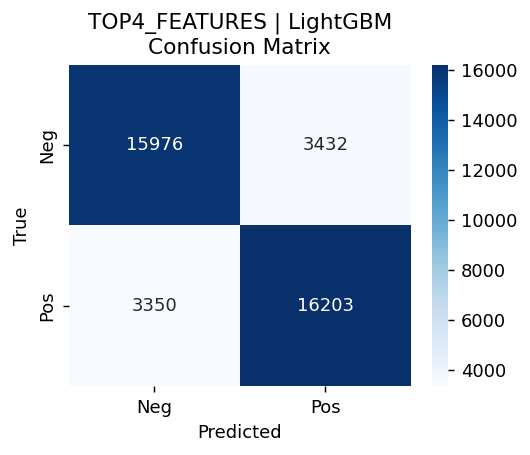

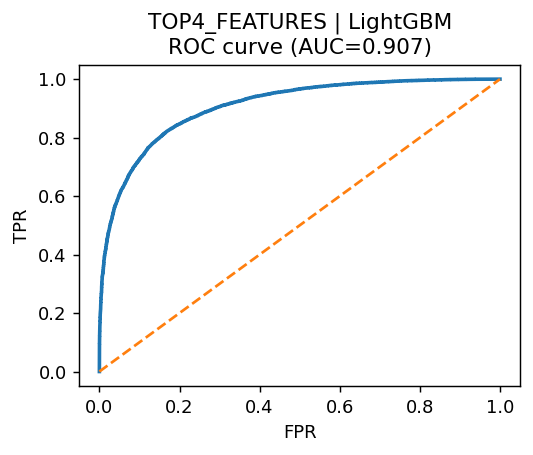

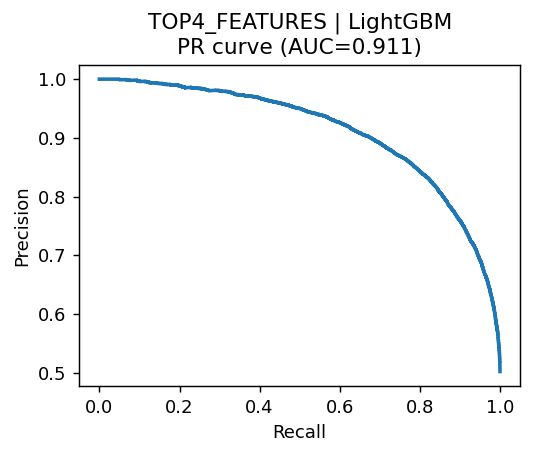

In [24]:
# ============================
# LightGBM — TOP 4 FEATURES  (logs suppressed)
#   Features: reviewText, title, genre, tomatoMeter
# ============================

from lightgbm import LGBMClassifier, log_evaluation

setup = "TOP4_FEATURES"
save_dir = os.path.join(BASE_SAVE_DIR, setup); os.makedirs(save_dir, exist_ok=True)

# ---- Build TOP-4 feature matrices (same as your LogReg/XGB TOP-4 block) ----
# Text: reviewText
train_review = train_df['reviewText'].map(clean_text)
test_review  = test_df['reviewText'].map(clean_text)
tfidf_review, Xtr_review = fit_tfidf(train_review, max_features=60000, ngram_range=(1,2), min_df=3)
Xte_review = transform_tfidf(tfidf_review, test_review)

# Text: title
train_title = train_df['title'].map(clean_text)
test_title  = test_df['title'].map(clean_text)
tfidf_title, Xtr_title = fit_tfidf(train_title, max_features=30000, ngram_range=(1,2), min_df=3)
Xte_title = transform_tfidf(tfidf_title, test_title)

# Categorical: genre (MultiLabelBinarizer)
train_genre = train_df['genre'].fillna("Unknown").str.split(', ')
test_genre  = test_df['genre'].fillna("Unknown").str.split(', ')
mlb_4 = MultiLabelBinarizer()
Xtr_genre = mlb_4.fit_transform(train_genre).astype(np.float32)
Xte_genre = mlb_4.transform(test_genre).astype(np.float32)
Xtr_genre = sparse.csr_matrix(Xtr_genre)
Xte_genre = sparse.csr_matrix(Xte_genre)

# Numeric: tomatoMeter (scaled on TRAIN only)
NUM_COLS_4 = ['tomatoMeter']
scaler_4, Xtr_num_np = fit_scale_numeric(train_df, NUM_COLS_4)
Xte_num_np = transform_scale_numeric(scaler_4, test_df, NUM_COLS_4)
Xtr_num = sparse.csr_matrix(Xtr_num_np.astype(np.float32))
Xte_num = sparse.csr_matrix(Xte_num_np.astype(np.float32))

# Stack TOP-4
X_train_TOP4 = sparse.hstack([Xtr_review, Xtr_title, Xtr_genre, Xtr_num], format='csr')
X_test_TOP4  = sparse.hstack([Xte_review, Xte_title, Xte_genre, Xte_num], format='csr')

# ---- Model (logs OFF) ----
lgb_top4 = LGBMClassifier(
    n_estimators=600, learning_rate=0.05, max_depth=-1, num_leaves=64,
    subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
    random_state=RNG, n_jobs=-1, verbosity=-1
)

# K-Fold on TRAIN
kfold_cv_report(lgb_top4, X_train_TOP4, y_train, "LightGBM (TOP4)")

# Fit on TRAIN, evaluate on TRAIN + TEST (suppress logging)
lgb_top4.fit(X_train_TOP4, y_train, callbacks=[log_evaluation(period=0)])

train_pred = lgb_top4.predict(X_train_TOP4)
test_pred  = lgb_top4.predict(X_test_TOP4)
test_prob  = lgb_top4.predict_proba(X_test_TOP4)[:,1]
train_prob = lgb_top4.predict_proba(X_train_TOP4)[:,1]

print("\nTrain accuracy:", accuracy_score(y_train, train_pred))
print("Test  accuracy:", accuracy_score(y_test,  test_pred))
evaluate_and_plot("LightGBM", setup, y_test, test_prob, test_pred, save_dir)

# Save artifacts
with open(os.path.join(save_dir, "LightGBM_TOP4.pkl"), "wb") as f:
    pickle.dump({
        "model":        lgb_top4,
        "tfidf_review": tfidf_review,
        "tfidf_title":  tfidf_title,
        "scaler":       scaler_4,
        "mlb":          mlb_4,
        "num_cols":     NUM_COLS_4
    }, f)


  Fold 1: acc=0.8047 | f1=0.8065
  Fold 2: acc=0.8087 | f1=0.8112
  Fold 3: acc=0.8062 | f1=0.8078
  Fold 4: acc=0.8053 | f1=0.8070
  Fold 5: acc=0.8049 | f1=0.8061
  LightGBM (TOP4) CV mean±std  |  acc=0.8060±0.0015  f1=0.8077±0.0018

Train accuracy: 0.818467659137577
Test  accuracy: 0.8046508046508046

[TOP4_FEATURES | LightGBM]  Accuracy=0.8047  F1=0.8060  Precision=0.8033  Recall=0.8088  ROC-AUC=0.8891  AP=0.8925

Classification report:
               precision    recall  f1-score   support

    Negative       0.81      0.80      0.80     19408
    Positive       0.80      0.81      0.81     19553

    accuracy                           0.80     38961
   macro avg       0.80      0.80      0.80     38961
weighted avg       0.80      0.80      0.80     38961



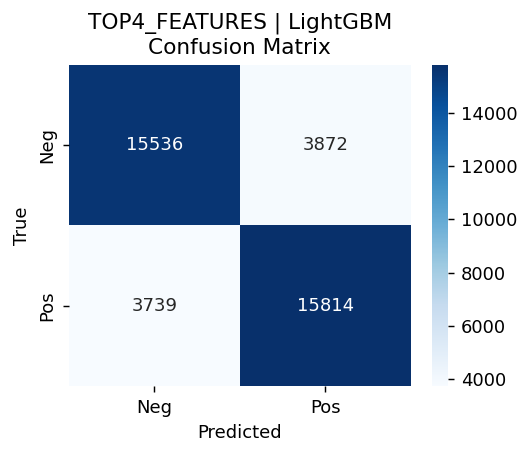

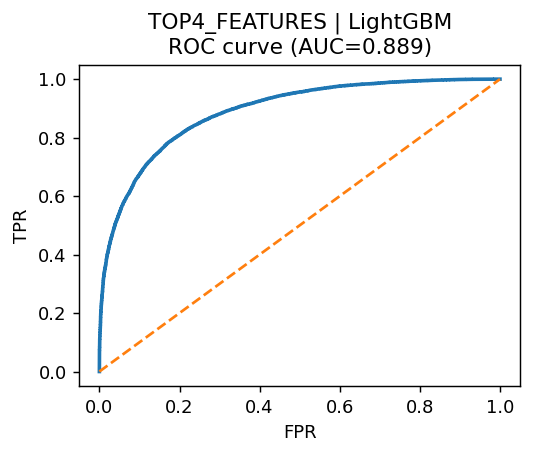

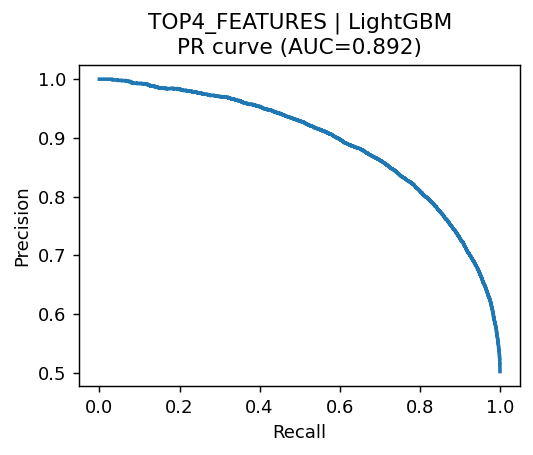

In [17]:
# ============================
# LightGBM — TOP 4 FEATURES  (logs suppressed)
#   Features: reviewText, title, genre, tomatoMeter
# ============================

from lightgbm import LGBMClassifier, log_evaluation

setup = "TOP4_FEATURES"
save_dir = os.path.join(BASE_SAVE_DIR, setup); os.makedirs(save_dir, exist_ok=True)

# ---- Build TOP-4 feature matrices (same as your LogReg/XGB TOP-4 block) ----
# Text: reviewText
train_review = train_df['reviewText'].map(clean_text)
test_review  = test_df['reviewText'].map(clean_text)
tfidf_review, Xtr_review = fit_tfidf(train_review, max_features=60000, ngram_range=(1,2), min_df=3)
Xte_review = transform_tfidf(tfidf_review, test_review)

# Text: title
train_title = train_df['title'].map(clean_text)
test_title  = test_df['title'].map(clean_text)
tfidf_title, Xtr_title = fit_tfidf(train_title, max_features=30000, ngram_range=(1,2), min_df=3)
Xte_title = transform_tfidf(tfidf_title, test_title)

# Categorical: genre (MultiLabelBinarizer)
train_genre = train_df['genre'].fillna("Unknown").str.split(', ')
test_genre  = test_df['genre'].fillna("Unknown").str.split(', ')
mlb_4 = MultiLabelBinarizer()
Xtr_genre = mlb_4.fit_transform(train_genre).astype(np.float32)
Xte_genre = mlb_4.transform(test_genre).astype(np.float32)
Xtr_genre = sparse.csr_matrix(Xtr_genre)
Xte_genre = sparse.csr_matrix(Xte_genre)

# Numeric: tomatoMeter (scaled on TRAIN only)
NUM_COLS_4 = ['tomatoMeter']
scaler_4, Xtr_num_np = fit_scale_numeric(train_df, NUM_COLS_4)
Xte_num_np = transform_scale_numeric(scaler_4, test_df, NUM_COLS_4)
Xtr_num = sparse.csr_matrix(Xtr_num_np.astype(np.float32))
Xte_num = sparse.csr_matrix(Xte_num_np.astype(np.float32))

# Stack TOP-4
X_train_TOP4 = sparse.hstack([Xtr_review, Xtr_title, Xtr_genre, Xtr_num], format='csr')
X_test_TOP4  = sparse.hstack([Xte_review, Xte_title, Xte_genre, Xte_num], format='csr')

# ---- Model (logs OFF) ----
# Stronger-regularized LightGBM to reduce overfitting (TEXT ONLY)
lgb_top4 = LGBMClassifier(
    n_estimators=790,          # more trees with smaller LR
    learning_rate=0.03,         # smaller step size
    num_leaves=31,              # simpler trees
    max_depth=-1,
    min_child_samples=100,      # require more samples per leaf
    min_child_weight=5.0,       # additional leaf constraint
    subsample=0.8,              # row sampling
    subsample_freq=1,
    colsample_bytree=0.7,       # feature sampling
    reg_lambda=10.0,            # stronger L2
    reg_alpha=1.0,              # add L1
    random_state=RNG, n_jobs=-1, verbosity=-1
)


# K-Fold on TRAIN
kfold_cv_report(lgb_top4, X_train_TOP4, y_train, "LightGBM (TOP4)")

# Fit on TRAIN, evaluate on TRAIN + TEST (suppress logging)
lgb_top4.fit(X_train_TOP4, y_train, callbacks=[log_evaluation(period=0)])

train_pred = lgb_top4.predict(X_train_TOP4)
test_pred  = lgb_top4.predict(X_test_TOP4)
test_prob  = lgb_top4.predict_proba(X_test_TOP4)[:,1]
train_prob = lgb_top4.predict_proba(X_train_TOP4)[:,1]

print("\nTrain accuracy:", accuracy_score(y_train, train_pred))
print("Test  accuracy:", accuracy_score(y_test,  test_pred))
evaluate_and_plot("LightGBM", setup, y_test, test_prob, test_pred, save_dir)

# Save artifacts
with open(os.path.join(save_dir, "LightGBM_TOP4_Updated.pkl"), "wb") as f:
    pickle.dump({
        "model":        lgb_top4,
        "tfidf_review": tfidf_review,
        "tfidf_title":  tfidf_title,
        "scaler":       scaler_4,
        "mlb":          mlb_4,
        "num_cols":     NUM_COLS_4
    }, f)


  Fold 1: acc=0.7424 | f1=0.7423
  Fold 2: acc=0.7390 | f1=0.7401
  Fold 3: acc=0.7429 | f1=0.7427
  Fold 4: acc=0.7396 | f1=0.7392
  Fold 5: acc=0.7418 | f1=0.7414
  LightGBM (TEXT ONLY) CV mean±std  |  acc=0.7411±0.0015  f1=0.7412±0.0013

Train accuracy: 0.7601578542094456
Test  accuracy: 0.7432047432047432

[TEXTONLY_FEATURE | LightGBM]  Accuracy=0.7432  F1=0.7423  Precision=0.7477  Recall=0.7370  ROC-AUC=0.8232  AP=0.8250

Classification report:
               precision    recall  f1-score   support

    Negative       0.74      0.75      0.74     19408
    Positive       0.75      0.74      0.74     19553

    accuracy                           0.74     38961
   macro avg       0.74      0.74      0.74     38961
weighted avg       0.74      0.74      0.74     38961



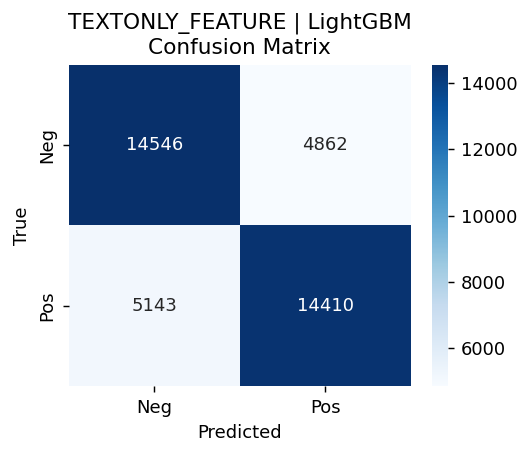

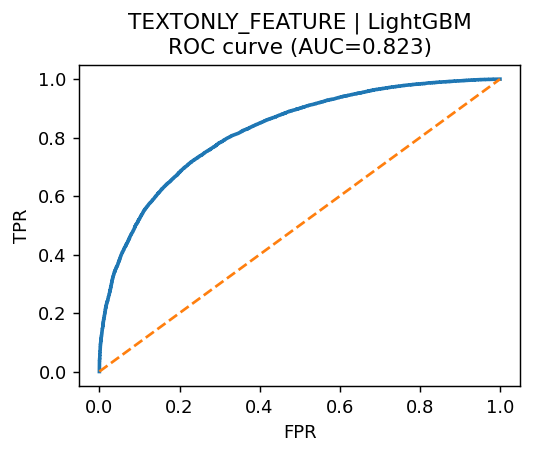

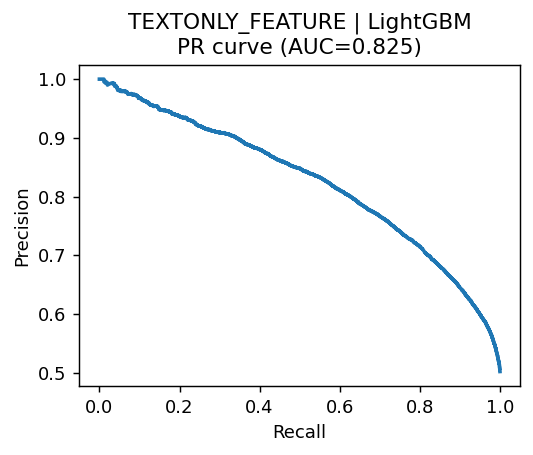

In [13]:
# ============================
# LightGBM — TEXT ONLY  (logs suppressed)
#   Feature: reviewText (TF-IDF)
# ============================

from lightgbm import LGBMClassifier, log_evaluation

setup = "TEXTONLY_FEATURE"
save_dir = os.path.join(BASE_SAVE_DIR, setup); os.makedirs(save_dir, exist_ok=True)

# ---- Build TEXT-ONLY matrices ----
train_review = train_df['reviewText'].map(clean_text)
test_review  = test_df['reviewText'].map(clean_text)

tfidf_review, Xtr_review = fit_tfidf(
    train_review,
    max_features=60000,
    ngram_range=(1,2),
    min_df=3
)
Xte_review = transform_tfidf(tfidf_review, test_review)

X_train_TEXT = Xtr_review
X_test_TEXT  = Xte_review

# ---- Model (logs OFF) ----
# Stronger-regularized LightGBM to reduce overfitting (TEXT ONLY)
lgb_text = LGBMClassifier(
    n_estimators=790,          # more trees with smaller LR
    learning_rate=0.03,         # smaller step size
    num_leaves=31,              # simpler trees
    max_depth=-1,
    min_child_samples=100,      # require more samples per leaf
    min_child_weight=5.0,       # additional leaf constraint
    subsample=0.8,              # row sampling
    subsample_freq=1,
    colsample_bytree=0.7,       # feature sampling
    reg_lambda=10.0,            # stronger L2
    reg_alpha=1.0,              # add L1
    random_state=RNG, n_jobs=-1, verbosity=-1
)


# K-Fold on TRAIN
kfold_cv_report(lgb_text, X_train_TEXT, y_train, "LightGBM (TEXT ONLY)")

# Fit on TRAIN, evaluate on TRAIN + TEST (suppress logging)
lgb_text.fit(X_train_TEXT, y_train, callbacks=[log_evaluation(period=0)])

train_pred = lgb_text.predict(X_train_TEXT)
test_pred  = lgb_text.predict(X_test_TEXT)
test_prob  = lgb_text.predict_proba(X_test_TEXT)[:,1]
train_prob = lgb_text.predict_proba(X_train_TEXT)[:,1]

print("\nTrain accuracy:", accuracy_score(y_train, train_pred))
print("Test  accuracy:", accuracy_score(y_test,  test_pred))
evaluate_and_plot("LightGBM", setup, y_test, test_prob, test_pred, save_dir)

# Save artifacts
with open(os.path.join(save_dir, "LightGBM_TEXTONLY.pkl"), "wb") as f:
    pickle.dump({
        "model":        lgb_text,
        "tfidf_review": tfidf_review
    }, f)
